In [242]:
from tensorflow.keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('weights.basic.best.h5')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0         
__________

In [243]:
def build_label(dataset):
  return [1 if "dog" in filename else 0 for filename in dataset ]

In [244]:
import os 
from random import shuffle

original_dataset_dir = './dataset/dogs_and_cats'
test_dir = os.path.join(original_dataset_dir, "train")
filenames = [filename for filename in os.listdir(test_dir)]

shuffle(filenames)

In [245]:
test_set = filenames[:5000]
test_label = build_label(test_set)

In [246]:
import pandas as pd
data = {"filename": test_set, "label": test_label}
test_df = pd.DataFrame(data)

In [247]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rescale=1./255)


test_datagenerator = image_generator.flow_from_dataframe(
  test_df, test_dir, y_col="label", target_size=(150,150),batch_size=100, class_mode="binary", shuffle=False)

Found 5000 images belonging to 2 classes.


In [248]:
scores = model.evaluate_generator(test_datagenerator, workers=6)

In [249]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 68.20%


In [250]:
target_file =os.path.join(test_dir,filenames[500])

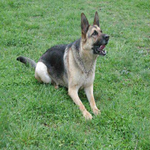

In [251]:
from copy import copy
from PIL import Image

img = Image.open(target_file) # image extension *.png,*.jpg
new_width  = 150
new_height = 150
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img

In [252]:
import numpy as np
img_vec = np.asarray(img) / 255

In [253]:
img_vec.shape 

(150, 150, 3)

In [254]:
img_vec = img_vec.reshape((-1, 150,150, 3))

In [255]:
img_vec.shape

(1, 150, 150, 3)

In [256]:
model.predict(img_vec)

array([[0.7908181]], dtype=float32)

In [257]:
from tensorflow.keras.preprocessing import image
import numpy as np

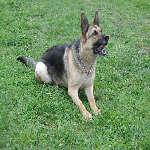

In [258]:
img = image.load_img(target_file, target_size=(150,150))
img

In [259]:
image.img_to_array(img).shape

(150, 150, 3)

In [260]:
image_tensor = image.img_to_array(img).reshape(1, 150, 150, 3)
image_tensor.shape

(1, 150, 150, 3)

In [261]:
image_tensor /= 255.

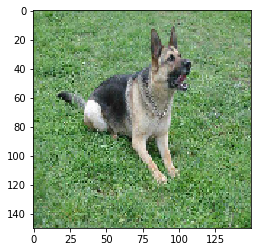

In [262]:
import matplotlib.pyplot as plt

plt.imshow(image_tensor[0])
plt.show()

In [263]:
from tensorflow.keras import models

In [264]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [265]:
layer_outputs

[<tf.Tensor 'Relu_48:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'MaxPool_36:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'Relu_49:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'MaxPool_37:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'Relu_50:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'MaxPool_38:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'Reshape_12:0' shape=(None, 36992) dtype=float32>,
 <tf.Tensor 'cond_11/Identity:0' shape=(None, 36992) dtype=float32>]

In [266]:
activations = activation_model.predict(image_tensor)
len(activations)

8

In [267]:
activations[0].shape

(1, 148, 148, 32)

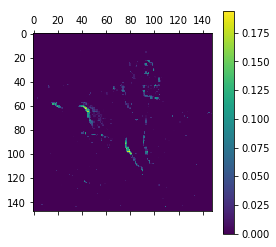

In [268]:

plt.matshow(activations[0][0, : , : , 0], cmap='viridis')
clb = plt.colorbar()


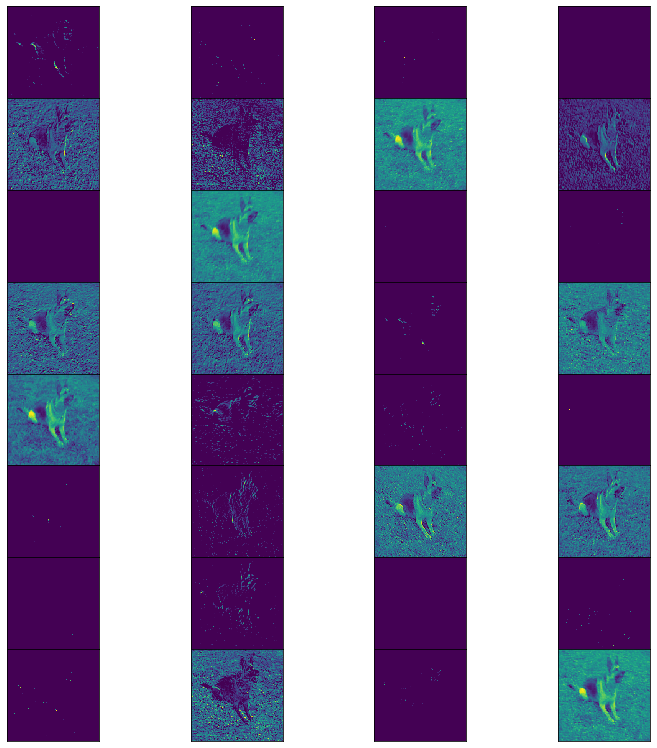

In [269]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8,8)) # Notice the equal aspect ratio
fig.set_size_inches(10.5, 10.5, forward=True)

ax = [fig.add_subplot(8,4,i+1) for i in range(32)]

for idx, a in enumerate(ax):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')

    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.matshow(activations[0][0, : , : , idx])
    
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

### 전체 중간층을 모두 활성화하여 보여주기

/home/sc82choi/miniconda3/envs/tf20/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


MemoryError: 

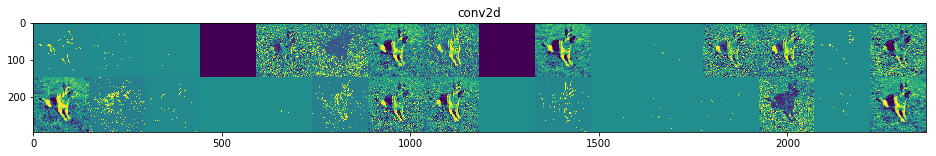

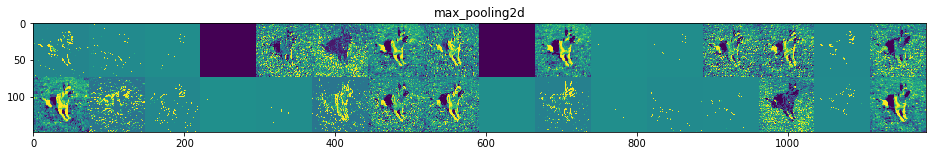

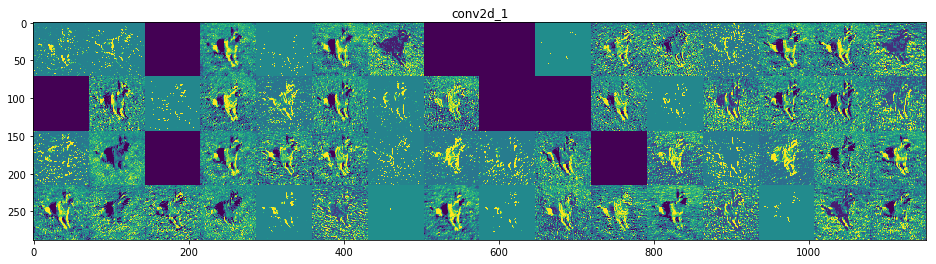

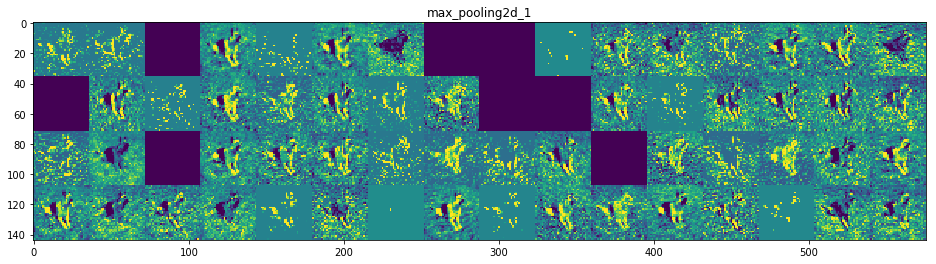

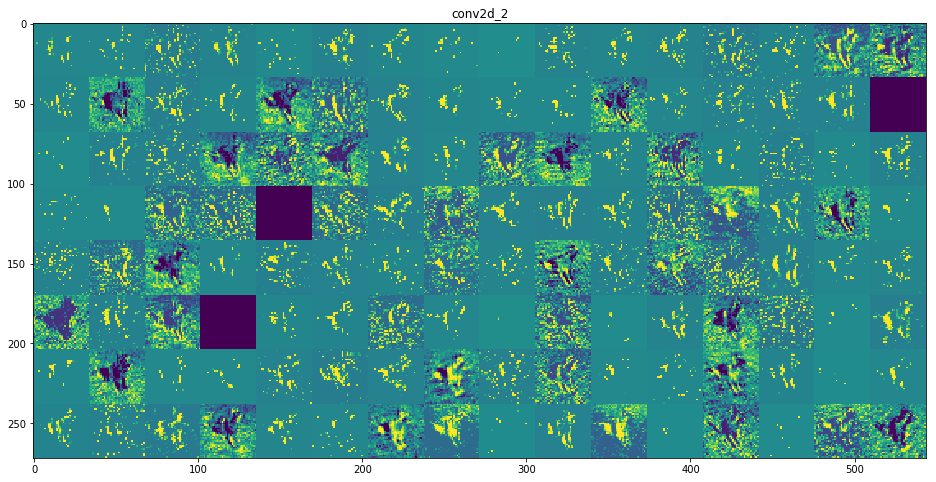

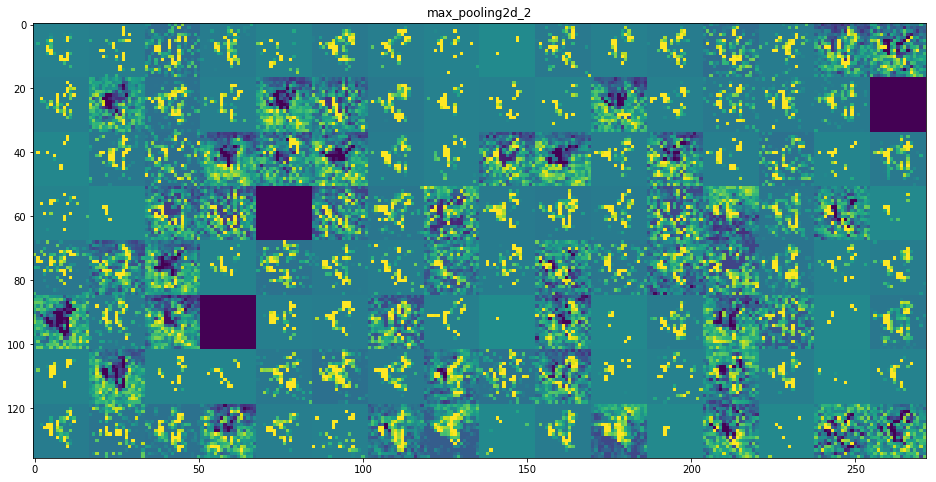

In [270]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()